# Why does L1 regularization encourage coefficients to shrink to zero?



## Introduction

Regularization is a common method for dealing with overfitting in Machine Learning (ML). The simplest and most widely used methods are L1 (Lasso) and L2 (Ridge). The L1 and L2 regularizations are well covered in numerous tutorials and books. However, I could not find any good geometric or intuitive explanation of why L1  encourages coefficients to shrink to zero. This post tries to address this. 

## Recap

### The Lasso 

The lasso regression is a linear regression model that shrinks the coefficients by imposing a constraint on their magnitude. Namely, it constrains the absolute values of the coefficients: 


$$
\begin{align}
  \hat{\beta}^{lasso} = \underset{\beta}{argmin} & \sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p{x_{ij}\beta_j} \right)^2\\
   \text{ subject to } & \sum_{j=1}^p|\beta_j| \le t
\end{align}
$$

The above equation is the equation (3.51) from "The Elements of Statistical Learning" (ESL) book by Hastie, Tibshirani, and Friedman. 

We can also write the lasso in the equivalent Lagrangian form (3.52), which penalizes the sum of the absolute values of the coefficients:

$$
\hat{\beta}^{lasso} = \underset{\beta}{argmin} 
\left\{
    \frac{1}{2}\sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p{x_{ij}\beta_j} \right)^2
    +\lambda\sum_{j=1}^p|\beta_j|
\right\}
$$

The equations (3.51) and (3.52) are equivalent under the correct $\lambda$ and $t$ hyperparameters. The latter equation (3.52) is more preferred in ML. 

Making $t$ sufficiently small will shrink some of the coefficients to be exactly zero, which we will give geometric intuition later. Thus, the lasso could be used for feature selection, i.e., for identifying unimportant features. 

### The Ridge

The ridge regression is similar to the lasso except it penalizes the sum-of-squares of the coefficients (3.41): 

$$
\hat{\beta}^{ridge} = \underset{\beta}{argmin} 
\left\{
    \frac{1}{2}\sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p{x_{ij}\beta_j} \right)^2
    +\lambda\sum_{j=1}^p\beta_j^2
\right\}
$$

An equivalent way to write the ridge problem is (3.42):

$$
\begin{align}
  \hat{\beta}^{ridge} = \underset{\beta}{argmin} & \sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p{x_{ij}\beta_j} \right)^2\\
   \text{ subject to } & \sum_{j=1}^p\beta_j^2 \le t
\end{align}
$$

The ridge regression will shrink the coefficient towards zero when $t$ is sufficiently small; however, the coefficients might not be exactly zero.

## Ridge vs Lasso

### Prior expalanations 

The best post I found so far is [https://explained.ai/regularization](https://explained.ai/regularization/), which explains the difference between L1 and L2 empirically by simulating random loss functions. I really encourage you to check out the tutorial.

Another explanation is given by the amazing The Elements of Statistical Learning book:

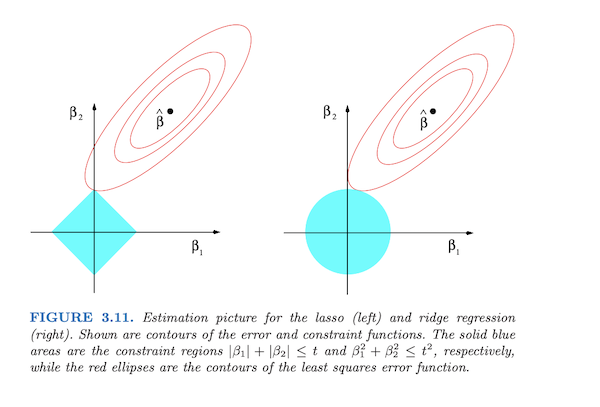

The constraint region for L2 is the disk $\beta_1^2+\beta_2^2 \le t$ (right figure), while it is the diamond $|\beta_1|+|\beta_2| \le t$ for L1 (left figure). Both methods find the first intersection point between the elliptical contours (loss) and the constrained region. The corners of the diamond have one parameter equal to zero. The diamond becomes a rhomboid in higher dimensional space, and has
many corners; there are many more opportunities to intersect at the corners. 

There are cool algebraic explanations as well, for example, given here [https://www.reddit.com/r/MachineLearning/...](https://www.reddit.com/r/MachineLearning/comments/1771jhl/d_how_does_l1_regularization_able_to_drive_a/). 

The explanations given by the book and other places are well-contained, but I could not fully grasp what's so special about the corners w.r.t the other points on the edges. There are only 4 corners and unlimited points on the edges, so shouldn't the probability to touch the other points be higher?



## Geometric Explanation

### Setup

We will use a simple loss function that illustrates circle contours instead of elliptical ones.: 

$$
Loss(\beta_1,\beta_2 | c_x, c_y)=2{(\beta_1 - c_x)}^2 + 2{(\beta_2 - c_y)}^2 + 100
$$ 

Once we understand the intution for circles, it is easy to extend to other contours such as elliptical ones. We will use $c_x=15$ and $c_y=5$ most of the time.

In [1]:
#| code-summary: code for loss setup and helper functions
#| code-fold: true


from enum import Enum

import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Polygon


def loss(b0, b1, cx, cy, scale=2.0, bias=100):
    return scale * (b0 - cx) ** 2 + scale * (b1 - cy) ** 2 + bias


class Reg(Enum):
    L1 = 1
    L2 = 2


def make_reg_shape(reg: Reg, t: float, color="k"):
    if reg == Reg.L1:
        return Polygon(xy=[(t, 0), (0, t), (-t, 0), (0, -t)], color=color, fill=False, linestyle='--')
    else:
        return Circle(xy=(0, 0), radius=t, color=color, fill=False, linestyle='--')


beta_range = -20, 20
cx, cy = 15, 5
vmax = 1000

In [2]:
#| code-summary: code for plot3d
#| code-fold: true

def base_fig3():
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("$\\beta_1$", labelpad=0)
    ax.set_ylabel("$\\beta_2$", labelpad=0)
    ax.set_zlim(0, 500)
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    ax.set_xlim(*beta_range)
    ax.set_ylim(*beta_range)
    # draw axes
    ax.plot(beta_range, [0, 0], color='k')
    ax.plot([0, 0], beta_range, color='k')
    return fig, ax


def plot3d(reg: Reg, t=3):
    fig, ax = base_fig3()

    # surface
    beta0 = np.linspace(*beta_range, 100)
    beta1 = np.linspace(*beta_range, 100)
    B0, B1 = np.meshgrid(beta0, beta1)
    Z = loss(B0, B1, cx=cx, cy=cy)
    ax.plot_surface(B0, B1, Z, alpha=0.7, cmap='coolwarm', vmax=vmax)

    # contours
    ax.plot([cx], [cy], marker='x', markersize=10, color='black')
    ax.contour(B0, B1, Z, levels=50, linewidths=.5, cmap='coolwarm', zdir='z', offset=0, vmax=vmax)

    # regularization contraints
    reg_shape = make_reg_shape(reg, t, color="black")
    ax.add_patch(reg_shape)
    art3d.pathpatch_2d_to_3d(reg_shape, z=0)

    ax.view_init(elev=39, azim=-106)
    plt.tight_layout()
    plt.show()

Let's visualize our loss $2{(\beta_1 - 15)}^2 + 2{(\beta_2 - 5)}^2 + 100$ with the L1 constaint $t=5$, i.e., $|\beta_1| + |\beta_2| \le 5$ in 3D:

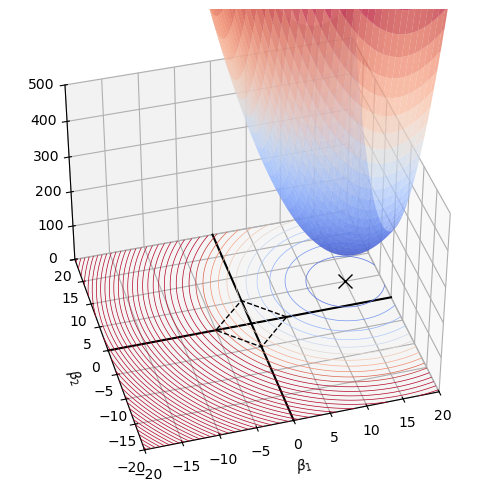

In [3]:
plot3d(Reg.L1, t=5)

In Lasso Regression, we're looking for $\beta_1$ and $\beta_2$ within the diamond that has the lowest loss. The global minima without any constraint is marked with "x" in the figure above.

The same visualization but with the L2 constraint t=5, i.e., $\beta_1^2+\beta_2^2 \le 5$:

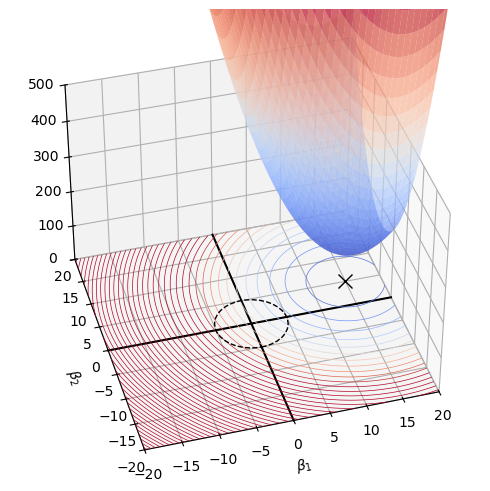

In [10]:
plot3d(Reg.L2, t=5)

The corresponding 2D visualizations similar to the figure given by the Elements of Statistical Learning book:

In [11]:
#| code-summary: code for plot2d
#| code-fold: true

def loss_contour(ax):
    beta0 = np.linspace(*beta_range, 100)
    beta1 = np.linspace(*beta_range, 100)
    B0, B1 = np.meshgrid(beta0, beta1)
    Z = loss(B0, B1, cx=cx, cy=cy)

    ax.contour(B0, B1, Z, levels=50, linewidths=.5, cmap='coolwarm', vmax=vmax)
    # draw the global minima
    ax.plot([cx], [cy], marker='x', markersize=10, color='black')


def ax2d_init(ax):
    ax.set_aspect('equal')
    ax.set_xlabel("$\\beta_1$", labelpad=0)
    ax.set_ylabel("$\\beta_2$", labelpad=0)
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    ax.set_xlim(*beta_range)
    ax.set_ylim(*beta_range)

    # draw axes
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')


def plot2d(regs: [Reg], t: float):
    fig = plt.figure(figsize=(4 * len(regs), 4))
    axes = fig.subplots(1, len(regs))
    for ax in axes:
        ax2d_init(ax)
    for reg, ax in zip(regs, axes):
        # draw the regularization safe region
        ax.add_patch(make_reg_shape(reg=reg, t=t))
        loss_contour(ax)
    plt.tight_layout()
    plt.show()

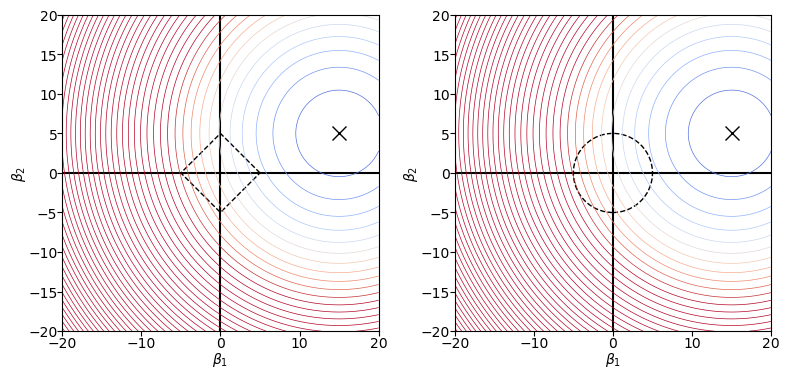

In [12]:
plot2d([Reg.L1, Reg.L2], t=5)

In both cases (L1, L2), we're looking for contours that just touches the constraint region. For example, if we have the below case:

In [27]:
#| code-summary: code for plot_reg_and_circle
#| code-fold: true

def plot_reg_and_circle(reg: Reg, t: float, cx: float, cy: float, radius: float):
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot()
    ax2d_init(ax)
    ax.add_patch(Circle(xy=(cx, cy), radius=radius, color='b', fill=False))
    ax.add_patch(make_reg_shape(reg, t=t))
    plt.tight_layout()
    plt.show()

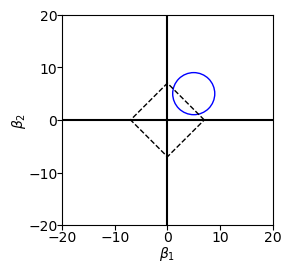

In [38]:
plot_reg_and_circle(Reg.L1, t=7, cx=5, cy=5, radius=4)

Then it is more optimal to reduce the constraint region (i.e., the diamond) until they just touch in a single point as shown below:

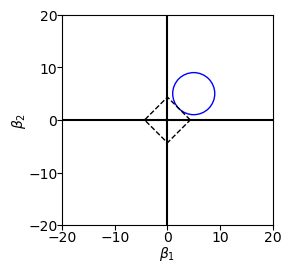

In [46]:
plot_reg_and_circle(Reg.L1, t=(np.sqrt(50)-4) * np.sqrt(2), cx=5, cy=5, radius=4)

In [42]:
import numpy as np
import itertools
from enum import Enum
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.path import Path
from matplotlib.patches import Circle, Polygon, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d


class Reg(Enum):
    L1 = 1
    L2 = 2


def loss(b0, b1, cx, cy, scale=2.0, bias=100):
    return scale * (b0 - cx) ** 2 + scale * (b1 - cy) ** 2 + bias


beta_range = -20, 20
cx, cy = 5, 15 
vmax = 1000


def base_fig2d():
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()
    ax.set_aspect('equal')
    ax.set_xlabel("$\\beta_1$", labelpad=0)
    ax.set_ylabel("$\\beta_2$", labelpad=0)
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    ax.set_xlim(*beta_range)
    ax.set_ylim(*beta_range)

    # draw axes
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

    return (fig, ax)


def make_reg_shape(reg: Reg, t: float, color="k"):
    if reg == Reg.L1:
        return Polygon(xy=[(t, 0), (0, t), (-t, 0), (0, -t)], color=color, fill=False, linestyle='--')
    else:
        return Circle(xy=(0, 0), radius=t, color=color, fill=False, linestyle='--')


def loss_contour(ax):
    beta0 = np.linspace(*beta_range, 100)
    beta1 = np.linspace(*beta_range, 100)
    B0, B1 = np.meshgrid(beta0, beta1)
    Z = loss(B0, B1, cx=cx, cy=cy)

    ax.contour(B0, B1, Z, levels=50, linewidths=.5, cmap='coolwarm', vmax=vmax)
    # draw the global minima
    ax.plot([cx], [cy], marker='x', markersize=10, color='black')
   

def plot2d(t, reg: Reg):
    _, ax = base_fig2d()

    # draw the regularization safe region
    ax.add_patch(make_reg_shape(reg=reg, t=t))
    loss_contour(ax)    
    plt.tight_layout()
    plt.show()


def l1_tangent_circle_locations(t: float, radius: float) -> list[np.array]:
    def is_corner(v):
        return min(abs(v[0]), abs(v[1])) <= radius / np.sqrt(2) + 1e-3

    vertices = make_reg_shape(Reg.L1, t=t+np.sqrt(2) * radius).get_path().interpolated(50).vertices
    vertices = vertices.tolist()
    new_vertices = []

    while is_corner(vertices[-1]):
        vertices.insert(0, vertices.pop(-1))
    vertices.reverse() 
    locations = []
    for i in range(8):
        should_be_corner = i % 2 == 0
        new_vertices = []
        while len(vertices) > 0 and is_corner(vertices[-1]) == should_be_corner: 
            v = vertices.pop()
            if should_be_corner:
                if abs(v[0]) <= abs(v[1]):
                    corner = [0, np.sign(v[1]) * t]
                else:
                    corner = [np.sign(v[0]) * t, 0]

                vec = np.array(v) - np.array(corner)
                vec = (vec / np.linalg.norm(vec)) * radius
                new_vertices.append(corner + vec)
            else:
                new_vertices.append(v)
        locations.append(np.array(new_vertices))
    return locations 


def plot_l1_and_circle(t: float, cx: float, cy: float, radius: float):
    fig, ax = base_fig2d()
    diamond = make_reg_shape(Reg.L1, t=t)
    circle = Circle(xy=(cx, cy), radius=radius, color='g', fill=False)

    circle_locations = l1_tangent_circle_locations(t, radius)
    plots = []
    for i, locations in enumerate(circle_locations): 
        color = 'g' if i % 2 == 0 else 'b'
        plots.append(ax.plot([], [], color=color, linewidth=2)[0])
    ax.add_patch(circle)
    ax.add_patch(diamond)
    def update(frame):
        remaining = frame
        for plot, locations in zip(plots, circle_locations):
            need = min(remaining, len(locations))
            remaining -= need
            plot.set_xdata(locations[:need, 0])
            plot.set_ydata(locations[:need, 1])
            if remaining == 0 and need > 0:
                last = locations[need - 1]
                circle.set_center(last)
                circle.set_color(plot.get_color())

    num_frames = np.sum([len(l) for l in circle_locations])
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, func=update, frames=range(0, num_frames, 2), interval=30)
    return ani


ani = plot_l1_and_circle(t=6, cx=7, cy=0, radius=6)

html=ani.to_html5_video()
plt.close()

from IPython.display import HTML
HTML(html)